COMP 3359 Artificial Intelligent Application Group One
Reimplementation of Neural Style Transfer Methods and Evaluation

In [2]:
# -*- coding: utf-8 -*-
"""
Created on Fri Apr 17 00:30:35 2020

@author: 潘慧杰
"""
import tensorflow as tf
import numpy as np
from glob import glob
from skimage.transform import resize
from skimage.io import imread, imshow,imsave
from tensorflow.keras.models import Model
import utils
import networks
from tensorflow.keras.applications.vgg16 import VGG16


"""
model 4 bulid
encoder
decoder
1.contentlosss 
2.style loss
3.normalization
4.loss network
5.style bank
because the tf.keras.Sequential can only built simple modle, in following example we will use 

"""

#arg:
CONTENT_WEIGHT = 50
STYLE_WEIGHT = 250
IDENTITY_WEIGHT = 10
REG_WEIGHT = 1e-7
BATCH_SIZE = 1

EPOCH = 300
T = 2
LAMBDA = 1

LR = 0.05
optimizer= tf.keras.optimizers.Adam(learning_rate=LR,decay=1e-4)
t = 0




CONTENT_LOSS = []
STYLE_LOSS = []
TOTAL_LOSS = []
VARIATION_LOSS = []
IDENTITY_LOSS= []

"""
#load the data.
"""

img_shape=(None, 224, 224, 3)
content_shape=(None, 224, 224, 3)
style_imgs_path="./style/"
content_imgs_path="./content/"
style_imgs = glob(style_imgs_path + '*')
content_imgs = glob(content_imgs_path + '*')
n_styles = len(style_imgs)
n_content_imgs = len(content_imgs)


content_images = np.array([
        resize(
        imread(img_path),
        img_shape[1:]
        ) * 255 for img_path in content_imgs
    ])
            
style_images =[imread(img_path) for img_path in style_imgs]       
style_images = np.array([
        resize(
        e if e.shape[0] < e.shape[1] else np.transpose(e, [1, 0, 2]),
        content_shape[1:]
        ) * 255 for e in style_images
    ])
        



CONTENT_LAYERS = [
                'block4_conv2'
                ]



STYLE_LAYERS = ['block1_conv2',
                'block2_conv2',
                'block3_conv2', 
                'block4_conv2',
                ]


model = networks.StyleBank(len(style_images),len(content_images))
vgg16 = VGG16(weights='imagenet')
output_s = [vgg16.get_layer(name).output for name in STYLE_LAYERS]
vgg16_s = Model(inputs=vgg16.input, outputs=output_s)
vgg16_s.trainable = False

output_c = [vgg16.get_layer(name).output for name in CONTENT_LAYERS]
vgg16_c = Model(inputs=vgg16.input, outputs=output_c)
vgg16_c.trainable = False








print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
gpu_device_name = tf.test.gpu_device_name()



"""
content_images = (image_size,H,W,C)
style_images = (image_size,H,W,C)
     
        
"""





/userhome/30/hjpan/miniconda3/envs/tensorflow/lib/python3.7/site-packages/tensorflow_addons/utils/ensure_tf_install.py:68: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.2.0 and strictly below 2.3.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.1.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  UserWarning,


Num GPUs Available:  0


'\ncontent_images = (image_size,H,W,C)\nstyle_images = (image_size,H,W,C)\n     \n        \n'

In [2]:
for i in range(EPOCH+600):
    if (i%100 == 0 and i>0):
        LR*= 0.8
        optimizer= tf.keras.optimizers.Adam(learning_rate=LR)
    for j in range(BATCH_SIZE):
        content_indexs = model.sample_train_batch(BATCH_SIZE, "content")
        style_indexs = model.sample_train_batch(BATCH_SIZE, "style")
        #two list to hold the branch index
        content_image_b = content_images[content_indexs]
        style_image_b = style_images[style_indexs]
        
        with tf.GradientTape() as tape:
            output_image_b = model.apply_style(content_image_b,style_indexs)
            output_image_g_features_b = [
                tf.map_fn(utils.gram_matrix, feature) for feature in vgg16_s.call(output_image_b)
            ]

            style_g_features = [
                tf.map_fn(utils.gram_matrix,feature) for feature in vgg16_s.call(tf.convert_to_tensor(style_image_b))
            ]
            
            output_image_features_b_s = vgg16_s.call(output_image_b)
            output_image_features_b_c = vgg16_c.call(output_image_b)
            style_features = vgg16_s.call(tf.convert_to_tensor(style_image_b))
            content_features_b = vgg16_c.call(tf.convert_to_tensor(content_image_b))

            

            style_loss = STYLE_WEIGHT* model.initialize_Ls(output_image_features_b_s,style_features)
            content_loss = CONTENT_WEIGHT * model.initialize_Lc(output_image_features_b_c,content_features_b)
            reg_loss = REG_WEIGHT * tf.math.reduce_mean(tf.image.total_variation(output_image_b))
            total_loss = content_loss + style_loss + reg_loss
            
            STYLE_LOSS.append(style_loss)
            CONTENT_LOSS.append(content_loss)
            VARIATION_LOSS.append(reg_loss)
            TOTAL_LOSS.append(total_loss)   
        gradients = tape.gradient(total_loss, model.trainable_variables)
        #!!!!!! check the varible
        en_de_variables = []
        for x in gradients:
            if x != None:
                en_de_variables.append(x)
        optimizer.apply_gradients(zip(en_de_variables, model.trainable_variables))

        t = t + 1
        if t == T + 1:
            t = 0
            with tf.GradientTape() as tape:
                identity_loss = model.initialize_Li(content_image_b)
                IDENTITY_LOSS.append(identity_loss)
            gradients = tape.gradient(identity_loss, model.trainable_variables)
            en_de_variables = []
            for x in gradients:
                if x != None:
                    en_de_variables.append(x)
                    
            optimizer.apply_gradients(zip(en_de_variables, model.trainable_variables))

    
    if ((i+1)%30 ==0 and i>100):
        print("Epoch: {}. Content loss: {}. Style loss: {} Variation loss {} IDENTITY_LOSS {}.\n Total Loss: {}. ".format(i+1,CONTENT_LOSS[-1],STYLE_LOSS[-1],VARIATION_LOSS[-1],IDENTITY_LOSS[-1],TOTAL_LOSS[-1]))
        img = resize(imread("./content/sea.jpg"), (500, 800, 3)) * 255
        img = np.expand_dims(img, axis=0)
        imgr = model.apply_style(img,[style_indexs[0]])
        imgr = imgr.numpy()
        imgr = imgr[0] - imgr.min()
        imgr = imgr / imgr.max()
        imsave("./image_result/new_s{}c{}e{} styled{}.jpg".format(CONTENT_WEIGHT,STYLE_WEIGHT,i,style_indexs[0]),imgr)
    if (i>500 and i%100==0):
        model.save_weights('./checkpoints/one_style{}'.format(i))
        
        
        



If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Epoch: 120. Cont

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 150. Content loss: 3291483.5. Style loss: 233605376.0 Variation loss 0.21604622900485992 IDENTITY_LOSS 5190.78369140625.
 Total Loss: 236896864.0. 


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 180. Content loss: 3107313.75. Style loss: 231533072.0 Variation loss 0.2331227958202362 IDENTITY_LOSS 8133.01806640625.
 Total Loss: 234640384.0. 


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 210. Content loss: 2725875.5. Style loss: 223569104.0 Variation loss 0.2189968079328537 IDENTITY_LOSS 5875.8359375.
 Total Loss: 226294976.0. 


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 240. Content loss: 3053497.5. Style loss: 210620448.0 Variation loss 0.26887258887290955 IDENTITY_LOSS 9908.5693359375.
 Total Loss: 213673952.0. 


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 270. Content loss: 6197615.0. Style loss: 186893120.0 Variation loss 0.2982809245586395 IDENTITY_LOSS 5783.611328125.
 Total Loss: 193090736.0. 


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 300. Content loss: 3973656.75. Style loss: 177758560.0 Variation loss 0.3414272665977478 IDENTITY_LOSS 6218.9140625.
 Total Loss: 181732224.0. 


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 330. Content loss: 6574598.5. Style loss: 147335712.0 Variation loss 0.36964428424835205 IDENTITY_LOSS 5431.50146484375.
 Total Loss: 153910304.0. 


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 360. Content loss: 5940011.5. Style loss: 125833112.0 Variation loss 0.42081859707832336 IDENTITY_LOSS 4892.8095703125.
 Total Loss: 131773120.0. 


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 390. Content loss: 4709700.0. Style loss: 121595832.0 Variation loss 0.4343845546245575 IDENTITY_LOSS 6654.7646484375.
 Total Loss: 126305536.0. 


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 420. Content loss: 4933422.5. Style loss: 97609416.0 Variation loss 0.46810150146484375 IDENTITY_LOSS 5873.51806640625.
 Total Loss: 102542840.0. 


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 450. Content loss: 5139990.0. Style loss: 87707480.0 Variation loss 0.4961664080619812 IDENTITY_LOSS 6057.4326171875.
 Total Loss: 92847472.0. 


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 480. Content loss: 7352287.5. Style loss: 74825296.0 Variation loss 0.5356391072273254 IDENTITY_LOSS 5474.43701171875.
 Total Loss: 82177584.0. 


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 510. Content loss: 6502395.0. Style loss: 87001744.0 Variation loss 0.5599105954170227 IDENTITY_LOSS 4763.75341796875.
 Total Loss: 93504136.0. 


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 540. Content loss: 6865237.5. Style loss: 56788788.0 Variation loss 0.6223754286766052 IDENTITY_LOSS 5031.23291015625.
 Total Loss: 63654024.0. 


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 570. Content loss: 5353161.5. Style loss: 62813252.0 Variation loss 0.6387513279914856 IDENTITY_LOSS 5981.8349609375.
 Total Loss: 68166416.0. 


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 600. Content loss: 5058022.0. Style loss: 76288256.0 Variation loss 0.6360107064247131 IDENTITY_LOSS 8705.5693359375.
 Total Loss: 81346280.0. 


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 630. Content loss: 5134831.5. Style loss: 52924712.0 Variation loss 0.6797322630882263 IDENTITY_LOSS 10400.5.
 Total Loss: 58059544.0. 


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 660. Content loss: 5156035.0. Style loss: 45051632.0 Variation loss 0.7063999176025391 IDENTITY_LOSS 10554.861328125.
 Total Loss: 50207668.0. 


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 690. Content loss: 5060374.0. Style loss: 98707256.0 Variation loss 0.704034149646759 IDENTITY_LOSS 4530.5654296875.
 Total Loss: 103767632.0. 


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 720. Content loss: 6914360.0. Style loss: 48430032.0 Variation loss 0.7416403293609619 IDENTITY_LOSS 5389.43896484375.
 Total Loss: 55344392.0. 


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 750. Content loss: 6974361.0. Style loss: 42634436.0 Variation loss 0.7693893909454346 IDENTITY_LOSS 5476.10693359375.
 Total Loss: 49608796.0. 


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 780. Content loss: 5222729.5. Style loss: 58882944.0 Variation loss 0.7533209323883057 IDENTITY_LOSS 8925.76171875.
 Total Loss: 64105672.0. 


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 810. Content loss: 5233447.5. Style loss: 53688620.0 Variation loss 0.7494226098060608 IDENTITY_LOSS 8762.4423828125.
 Total Loss: 58922068.0. 


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 840. Content loss: 7142428.0. Style loss: 35495060.0 Variation loss 0.7837013602256775 IDENTITY_LOSS 5737.59375.
 Total Loss: 42637488.0. 


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 870. Content loss: 5480097.5. Style loss: 61025616.0 Variation loss 0.7536818385124207 IDENTITY_LOSS 4771.16259765625.
 Total Loss: 66505712.0. 


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch: 900. Content loss: 5794680.0. Style loss: 35275260.0 Variation loss 0.7704706192016602 IDENTITY_LOSS 6570.13671875.
 Total Loss: 41069940.0. 


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


In [4]:
 model.load_weights('./checkpoints/one_style{}'.format(800))

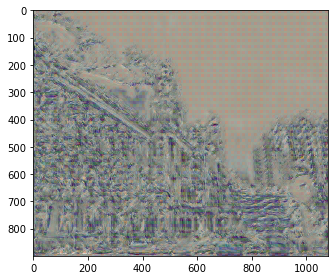

In [13]:
img = resize(imread("./content/content02.jpg"), (900, 1080, 3)) * 255
img = np.expand_dims(img, axis=0)
imgr = model.apply_style(img,[0])
imgr = imgr.numpy()
imgr = imgr[0] - imgr.min()
imgr = imgr / imgr.max()
imshow(imgr)


In [14]:
imsave("./image_result/one.jpg",imgr)

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
